In [50]:
import pandas as pd
import numpy as np
# plotting
import seaborn as sns
import matplotlib.pyplot as plt

# Modelling
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import tree
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
# import graphviz
# Scaling with Minmax-scaler
from sklearn.preprocessing import MinMaxScaler

# from ydata_profiling import ProfileReport

# import custom functions
from custom_functions import our_metrics

# import custom scorers
from custom_functions import get_kappa

# pd.set_option('display.max_rows', None)

RSEED = 42

## Importing the Data

In [51]:
# reading in the data sets (for distance based models with dropped first column during dummy creation in order to avoid collinearity)
X_test = pd.read_csv('../data/petfinder-adoption-prediction/train/X_test_minmax_scaled_dropped_first.csv', delimiter=',')
X_train = pd.read_csv('../data/petfinder-adoption-prediction/train/X_train_minmax_scaled_dropped_first.csv', delimiter=',')
y_test = pd.read_csv('../data/petfinder-adoption-prediction/train/y_test.csv', delimiter=',')
y_train = pd.read_csv('../data/petfinder-adoption-prediction/train/y_train.csv', delimiter=',')

### Splitting DataFrames into Cats and Dogs 

In [54]:
X_train_cats = X_train.query("type == 1").drop('type', axis=1) # 0 dog, 1 cat
X_train_dogs = X_train.query("type == 0").drop('type', axis=1)
X_test_cats = X_test.query("type == 1").drop('type', axis=1)
X_test_dogs = X_test.query("type == 0").drop('type', axis=1)

In [55]:
ix_train_cats = X_train_cats.index.to_list()
ix_train_dogs = X_train_dogs.index.to_list()
ix_test_cats = X_test_cats.index.to_list()
ix_test_dogs = X_test_dogs.index.to_list()

In [56]:
y_train_cats = y_train.loc[y_train.index[ix_train_cats]]
y_train_dogs = y_train.loc[y_train.index[ix_train_dogs]]
y_test_cats = y_train.loc[y_train.index[ix_test_cats]]
y_test_dogs = y_train.loc[y_train.index[ix_test_dogs]]

In [58]:
# change format of y from dataframe to array
y_test = np.ravel(y_test)
y_train = np.ravel(y_train)
y_train_cats = np.ravel(y_train_cats)
y_train_dogs = np.ravel(y_train_dogs)
y_test_cats = np.ravel(y_test_cats)
y_test_dogs = np.ravel(y_test_dogs)

## Predictive Modelling with a Logistic Regression

In [26]:
# Logistic Regression
log_reg = LogisticRegression(max_iter=1000)
log_reg.fit(X_train, y_train)

y_pred_train = log_reg.predict(X_train)
y_pred_test = log_reg.predict(X_test)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3911
_____________________
Weighted Quadratic Kappa: 0.2938


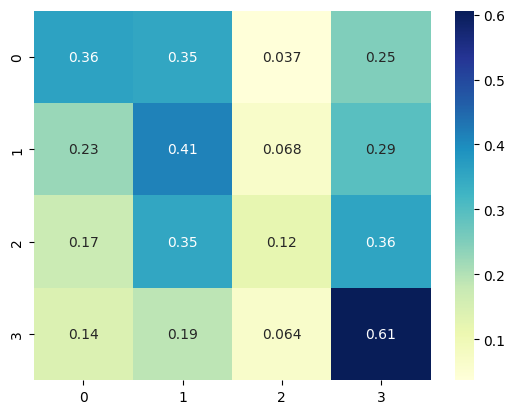

In [27]:
our_metrics(y_train, y_pred_train, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.375
_____________________
Weighted Quadratic Kappa: 0.2426


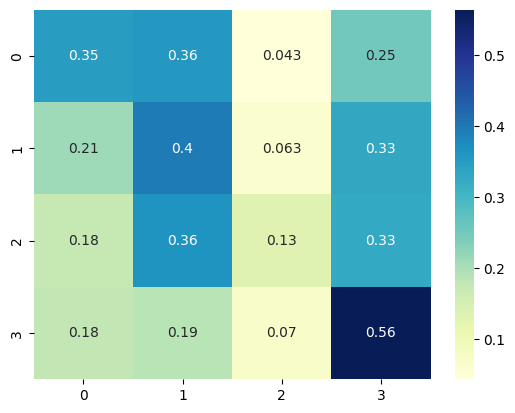

In [28]:
our_metrics(y_test, y_pred_test, normalize=True)

## Hyperparameter Tuning with Random Search

### Accuracy Scorer

In [29]:
#what parameters does LogisticRegression have?
log_reg.get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

### Hyperparameters of the LogisticRegression

- 'C' : float, default=1.0
Inverse of regularization strength; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- 'class_weight' : dict or ‘balanced’, default=None
Weights associated with classes in the form {class_label: weight}. If not given, all classes are supposed to have weight one.
- 'dual' : bool, default=False
Dual or primal formulation. Dual formulation is only implemented for l2 penalty with liblinear solver. Prefer dual=False when n_samples > n_features.
- 'fit_intercept' : bool, default=True
Specifies if a constant (a.k.a. bias or intercept) should be added to the decision function.
- 'intercept_scaling' : float, default=1
Useful only when the solver ‘liblinear’ is used and ...
- 'l1_ratio': float, default=None
The Elastic-Net mixing parameter, with 0 <= l1_ratio <= 1. Only used if penalty='elasticnet'. Setting l1_ratio=0 is equivalent to using penalty='l2', while setting l1_ratio=1 is equivalent to using penalty='l1'. For 0 < l1_ratio <1, the penalty is a combination of L1 and L2.
- 'max_iter' : int, default=100
Maximum number of iterations taken for the solvers to converge
- 'multi_class': {‘auto’, ‘ovr’, ‘multinomial’}, default=’auto’
If the option chosen is ‘ovr’, then a binary problem is fit for each label. For ‘multinomial’ the loss minimised is the multinomial loss fit across the entire probability distribution, even when the data is binary. ‘multinomial’ is unavailable when solver=’liblinear’. ‘auto’ selects ‘ovr’ if the data is binary, or if solver=’liblinear’, and otherwise selects ‘multinomial’.
- n_jobs': int, default=None
- 'penalty' : {‘l1’, ‘l2’, ‘elasticnet’, None}, default=’l2’
- 'random_state' : int, RandomState instance, default=None
Used when solver == ‘sag’, ‘saga’ or ‘liblinear’ to shuffle the data.
- 'solver' : {‘lbfgs’, ‘liblinear’, ‘newton-cg’, ‘newton-cholesky’, ‘sag’, ‘saga’}, default=’lbfgs’
Algorithm to use in the optimization problem. Default is ‘lbfgs’. To choose a solver, you might want to consider the following aspects:
For small datasets, ‘liblinear’ is a good choice, whereas ‘sag’ and ‘saga’ are faster for large ones;
For multiclass problems, only ‘newton-cg’, ‘sag’, ‘saga’ and ‘lbfgs’ handle multinomial loss;
‘liblinear’ is limited to one-versus-rest schemes.
‘newton-cholesky’ is a good choice for n_samples >> n_features, especially with one-hot encoded categorical features with rare categories. Note that it is limited to binary classification and the one-versus-rest reduction for multiclass classification. Be aware that the memory usage of this solver has a quadratic dependency on n_features because it explicitly computes the Hessian matrix.
Warning: The choice of the algorithm depends on the penalty chosen. Supported penalties by solver:
‘lbfgs’ - [‘l2’, None]
‘liblinear’ - [‘l1’, ‘l2’]
‘newton-cg’ - [‘l2’, None]
‘newton-cholesky’ - [‘l2’, None]
‘sag’ - [‘l2’, None]
‘saga’ - [‘elasticnet’, ‘l1’, ‘l2’, None]
- 'tol' : float, default=1e-4
Tolerance for stopping criteria.
- 'verbose' : int, default=0
For the liblinear and lbfgs solvers set verbose to any positive number for verbosity.
- 'warm_start' : bool, default=False
When set to True, reuse the solution of the previous call to fit as initialization, otherwise, just erase the previous solution. Useless for liblinear solver.

In [30]:
 # Define parameter grid for randomized search
param_grid = {'C' : np.linspace(0.0001, 1, 50),
              'l1_ratio' : np.linspace(0, 1, 50), 
              'penalty' : ['l1', 'l2', 'elasticnet', None],
              'solver' : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga']
             }

In [31]:
#multi_class=‘auto’/‘multinomial’ multi_class='multinomial'
# Instantiate random search and define the metric to optimize 
rs = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid, scoring='accuracy',
                  cv=5, verbose=5, n_jobs=-1, n_iter=40, random_state=RSEED)

In [32]:
# Fit randomized search object to data
rs.fit(X_train, y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 1/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.382 total time=   0.3s
[CV 1/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.399 total time=   0.3s
[CV 4/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.382 total time=   0.4s
[CV 5/5] END C=0.9591877

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 1/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.399 total time=   0.4s
[CV 5/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.380 total time=   0.4s
[CV 4/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.382 total time=   0.4s
[CV 2/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.382 total time=   0.3s
[CV 1/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.399 total time=   0.3s
[CV 4/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.382 total time=   0.3s
[CV 1/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.401 total time=   0.1s
[CV 2/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.387 total time=   0.1s
[CV 3/5] END C=0.9183755102040816,

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefisc

[CV 4/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.383 total time=   0.1s
[CV 5/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.380 total time=   0.3s
[CV 5/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.379 total time=   0.1s
[CV 1/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 2/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.382 total time=   0.3s
[CV 1/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.399 total time=   0.3s
[CV 4/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.382 total time=   0.3s
[CV 5/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.380 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 2/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.382 total time=   0.2s
[CV 1/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.399 total time=   0.3s
[CV 4/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.382 total time=   0.3s
[CV 5/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.380 total time=   0.3s
[CV 3/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.395 total time=   0.7s
[CV 1/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.390 total time=   0.2s
[CV 2/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.386 total time=   0.2s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasse

[CV 2/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.389 total time=   0.1s
[CV 5/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.386 total time=   0.2s
[CV 5/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.376 total

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 2/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.382 total time=   0.4s
[CV 1/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.399 total time=   0.4s
[CV 2/5] END C=0.36741020408163266, l1_ratio=0.3061224489795918, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.36741020408163266, l1_ratio=0.3061224489795918, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.36741020408163266, l1_ratio=0.3061224489795918, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.36741020408163266, l1_ratio=0.3061224489795918, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.36741020408163266, l1_ratio=0.3061224489795918, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.382 total time=   0.3s
[CV 2/5] END C=0.7959387755102041, l1_ratio=0.32

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacas

[CV 1/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.395 total time=   0.6s
[CV 5/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.2653795918367347, l1_ratio=0.3469387755102041, penalty=elasticnet, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5] END C=0.7959387755102041, l1_ratio=0.32653061224489793, penalty=l2, solver=liblinear;, score=0.383 total time=   0

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasse

[CV 2/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.385 total time=   0.1s
[CV 1/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.395 total time=   0.1s
[CV 1/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.399 total time=   0.2s
[CV 5/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.380 total time=   0.2s
[CV 3/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.393 total time=   0.1s
[CV 1/5] END C=0.9387816326530612, l1_ratio=0.7551020408163265, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefi

[CV 2/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.382 total time=   0.3s
[CV 1/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.382 total time=   0.2s
[CV 1/5] END C=0.897969387755102, l1_ratio=0.7551020408163265, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.897969387755102, 

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 3/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.390 total time=   0.2s
[CV 1/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.398 total time=   0.3s
[CV 5/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.380 total time=   0.3s
[CV 2/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.10213061224489796, l1_ratio=0.32653061224489793, penalty=elasticnet

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.377 total time=   0.2s
[CV 1/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.395 total time=   0.7s
[CV 3/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.393 total time=   0.2s
[CV 2/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=  

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasse

[CV 1/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.397 total time=   0.2s
[CV 5/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.375 total time=   0.2s
[CV 4/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.382 total time=   0.2s
[CV 5/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.376 total time=   0.2s
[CV 1/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.382 total time=   0.2s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacas

[CV 1/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.397 total time=   0.2s
[CV 5/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.378 total time=   0.2s
[CV 3/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.390 total time=   0.2s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.388 total time=   0.2s
[CV 1/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.399 total time=   0.2s
[CV 4/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.381 total time=   0.2s
[CV 3/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.395 total time=   0.2s
[CV 2/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.380 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefisc

[CV 3/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.391 total time=   0.1s
[CV 2/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.382 total time=   0.3s
[CV 1/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.399 total time=   0.2s
[CV 4/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.376 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 5/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.376 total time=   0.1s
[CV 1/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.380 total time=   0.2s
[CV 2/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.382 total time=   0.2s
[CV 1/5] END C=0.0001, l1_ratio=0.1428571428571

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 3/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.395 total time=   5.6s
[CV 3/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.395 total time=   5.2s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.395 total time=   5.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.395 total time=   4.6s
[CV 4/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.382 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capsto

[CV 3/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.395 total time=   3.8s
[CV 4/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.382 total time=   0.1s
[CV 5/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.380 total time=   0.1s
[CV 1/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.395 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 3/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.395 total time=   3.3s
[CV 4/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.382 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.05061224e-02, 4.09122449e-02, 6.13183673e-02,
       8.17244898e-02, 1.02130612e-01, 1.22536735e-01, 1.42942857e-01,
       1.63348980e-01, 1.83755102e-01, 2.04161224e-01, 2.24567347e-01,
       2.44973469e-01, 2.65379592e-01, 2.85...
       0.6122449 , 0.63265306, 0.65306122, 0.67346939, 0.69387755,
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42, scoring='accuracy', verbose=5)

In [33]:
# Best score
print('Best score:', round(rs.best_score_, 3))

# Best parameters
print('Best parameters:', rs.best_params_)

Best score: 0.389
Best parameters: {'solver': 'newton-cholesky', 'penalty': None, 'l1_ratio': 0.14285714285714285, 'C': 0.0001}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3772
_____________________
Weighted Quadratic Kappa: 0.2474


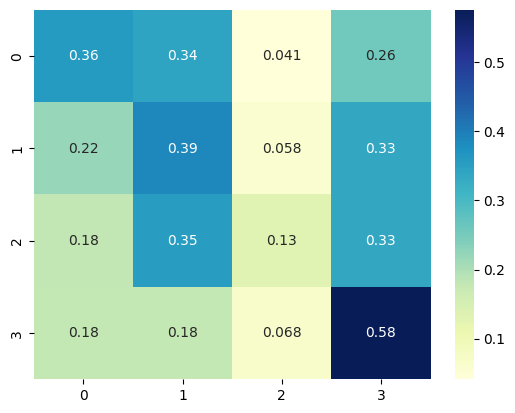

In [34]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs
log_reg_best_rs = rs.best_estimator_

# Making predictions on the test set
y_pred_test_rs = log_reg_best_rs.predict(X_test)

# Let us print out the performance of our model on the test set.
our_metrics(y_test, y_pred_test_rs, normalize=True)

## RandomSearch with Quadratic Weighted Kappa Scorer

In [35]:
# make the kappa scorers needed for the grid search
kappa_scorer = get_kappa()

In [36]:
#multi_class=‘auto’/‘multinomial’
# Instantiate random search and define the metric to optimize 
rs_kappa = RandomizedSearchCV(LogisticRegression(random_state=RSEED,max_iter=1000), param_grid, scoring=kappa_scorer,
                  cv=5, verbose=5, n_jobs=-1, n_iter=50, random_state=RSEED)

In [37]:
# Fit randomized search object to data
rs_kappa.fit(X_train, y_train)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
[CV 1/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 5/5] END C=0.2653795918367347, l1_ratio=0.16326530612244897, penalty=l1, solver=newton-cholesky;, score=nan total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 2/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.303 total time=   0.4s
[CV 2/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.303 total time=   0.4s
[CV 5/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.274 total time=   0.4s
[CV 1/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.301 total time=   0.4s
[CV 4/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.292 total time=   0.5s
[CV 1/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.301 total time=   0.5s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 1/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.300 total time=   0.1s
[CV 2/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.308 total time=   0.2s
[CV 4/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.292 total time=   0.4s
[CV 4/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.292 total time=   0.4s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacas

[CV 2/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.303 total time=   0.4s
[CV 5/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.274 total time=   0.4s
[CV 1/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.301 total time=   0.4s
[CV 3/5] END C=0.0001, l1_ratio=0.7142857142857142, penalty=None, solver=newton-cg;, score=0.286 total time=   0.8s
[CV 1/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.18375510204081633, l1_ratio=0.4081632653061224, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 5/5] END C=0.18375510204081633, l1_ratio=0.4

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 4/5] END C=0.9183755102040816, l1_ratio=0.2857142857142857, penalty=l2, solver=liblinear;, score=0.296 total time=   0.2s
[CV 5/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.274 total time=   0.4s
[CV 2/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.303 total time=   0.4s
[CV 4/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.292 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 1/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.301 total time=   0.5s
[CV 1/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.301 total time=   0.5s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(


[CV 4/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.292 total time=   0.4s
[CV 1/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.291 total time=   0.2s
[CV 2/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.303 total time=   0.5s
[CV 5/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.274 total time=   0.4s
[CV 3/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.279 total time=   0.2s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefi

[CV 2/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.302 total time=   0.2s
[CV 2/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.284 total time=   0.2s
[CV 5/5] END C=0.10213061224489796, l1_ratio=0.22448979591836732, penalty=l1, solver=liblinear;, score=0.259 total time=   0.2s
[CV 1/5] END C=0.28578571428571425, l1_ratio=0.04081632653061224, penalty=l1, solver=newton-cg;, score=nan total

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 1/5] END C=0.7959387755102041, l1_ratio=0.32653061224489793, penalty=l2, solver=liblinear;, score=0.297 total time=   0.2s
[CV 3/5] END C=0.7551265306122449, l1_ratio=0.26530612244897955, penalty=None, solver=newton-cg;, score=0.286 total time=   1.0s
[CV 1/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.301 total time=   0.4s
[CV 2/5] END C=0.7959387755102041, l1_ratio=0.32653061224489793, penalty=l2, solver=liblinear;, score=0.306 total time=   0.2s
[CV 5/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.276 total time=   0.4s
[CV 1/5] END C=0.36741020408163266, l1_ratio=0.3061224489795918, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefisc

[CV 3/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.7959387755102041, l1_ratio=0.32653061224489793, penalty=l2, solver=liblinear;, score=0.284 total time=   0.2s
[CV 4/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.7347204081632653, l1_ratio=0.7755102040816326, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.2653795918367347, l1_ratio=0.3469387755102041, penalty=elasticnet, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 2/5] END C=0.2653795918367347, l1_ratio=0.3469387755102041, penalty=elasticnet, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 3/5] END C=0.2653795918367347, l1_ratio=0.3469387755102041, penalty=elasticnet, solver=newton-cholesky;, score=nan total time=   0.0s
[CV 4/5] END C=0.2653795918367347, l1_ratio=0.3469387755102041, penalty=elasticne

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefi

[CV 1/5] END C=0.02050612244897959, l1_ratio=0.4081632653061224, penalty=l1, solver=saga;, score=0.265 total time=   0.2s
[CV 3/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.287 total time=   0.8s
[CV 3/5] END C=0.02050612244897959, l1_ratio=0.4081632653061224, penalty=l1, solver=saga;, score=0.255 total time=   0.2s
[CV 2/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.303 total time=   0.5s
[CV 2/5] END C=0.0001, l1_ratio=0.6530612244897959, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 3/5] END C=0.0001, l1_ratio=0.6530612244897959, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.02050612244897959, l1_ratio=0.4081632653061224, penalty=l1, solver=saga;, score=0.234 total time=   0.3s
[CV 1/5] END C=0.0001, l1_ratio=0.6530612244897959, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefisc

[CV 4/5] END C=0.0001, l1_ratio=0.6530612244897959, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 5/5] END C=0.0001, l1_ratio=0.6530612244897959, penalty=l1, solver=liblinear;, score=0.000 total time=   0.0s
[CV 2/5] END C=0.02050612244897959, l1_ratio=0.4081632653061224, penalty=l1, solver=saga;, score=0.283 total time=   0.2s
[CV 4/5] END C=0.02050612244897959, l1_ratio=0.4081632653061224, penalty=l1, solver=saga;, score=0.256 total time=   0.2s
[CV 2/5] END C=0.9387816326530612, l1_ratio=0.7551020408163265, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.9387816326530612, l1_ratio=0.7551020408163265, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.9387816326530612, l1_ratio=0.7551020408163265, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.9387816326530612, l1_ratio=0.7551020408163265, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanac

[CV 2/5] END C=0.04091224489795919, l1_ratio=0.02040816326530612, penalty=l2, solver=newton-cholesky;, score=0.292 total time=   0.0s
[CV 4/5] END C=0.6122836734693877, l1_ratio=1.0, penalty=None, solver=lbfgs;, score=0.292 total time=   0.4s
[CV 3/5] END C=0.04091224489795919, l1_ratio=0.02040816326530612, penalty=l2, solver=newton-cholesky;, score=0.270 total time=   0.0s
[CV 5/5] END C=0.04091224489795919, l1_ratio=0.02040816326530612, penalty=l2, solver=newton-cholesky;, score=0.268 total time=   0.0s
[CV 4/5] END C=0.04091224489795919, l1_ratio=0.02040816326530612, penalty=l2, solver=newton-cholesky;, score=0.272 total time=   0.1s
[CV 1/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.301 total time=   0.3s
[CV 2/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.304 total time=   0.1s
[CV 1/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.295 total time

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasse

[CV 5/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.274 total time=   0.4s
[CV 1/5] END C=0.9387816326530612, l1_ratio=0.7551020408163265, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 1/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 5/5] END C=0.6326897959183674, l1_ratio=0.5102040816326531, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.285 total time=   0.2s
[C

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 5/5] END C=0.08172448979591837, l1_ratio=0.42857142857142855, penalty=l2, solver=liblinear;, score=0.264 total time=   0.1s
[CV 2/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.303 total time=   0.5s
[CV 1/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 2/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 3/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 4/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 5/5] END C=0.28578571428571425, l1_ratio=0.6530612244897959, penalty=l1, solver=lbfgs;, score=nan total time=   0.0s
[CV 1/5] END C=0.897969387755102, l1_ratio=0.7551020408163265, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.897969387755102, 

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 2/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.303 total time=   0.3s
[CV 1/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.301 total time=   0.5s
[CV 4/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.292 total time=   0.4s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 1/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.301 total time=   0.4s
[CV 3/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.284 total time=   0.3s
[CV 5/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.274 total time=   0.4s
[CV 2/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.309 total time=   0.4s
[CV 4/5] END C=0.32659795918367346, l1_ratio=0.4693877551020408, penalty=elasticnet, solver=saga;, score=0.288 total time=   0.3s
[CV 2/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.4694408163265306, l1_ratio=0.9183673469387754, penalty=elasticnet, solv

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasse

[CV 3/5] END C=0.6530959183673469, l1_ratio=0.6530612244897959, penalty=None, solver=newton-cg;, score=0.286 total time=   0.9s
[CV 2/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.4286285714285714, l1_ratio=0.3877551020408163, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 1/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.298 total time=   0.2s
[CV 3/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.289 total time=   0.3s
[CV 5/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.274 total time=   0.3s
[CV 1/5] END C=0

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.298 total time=   0.3s
[CV 2/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.310 total time=   0.3s
[CV 4/5] END C=0.6939081632653061, l1_ratio=0.5306122448979591, penalty=l2, solver=sag;, score=0.293 total time=   0.2s
[CV 3/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.287 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 2/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.307 total time=   0.3s
[CV 5/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.269 total time=   0.3s
[CV 2/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.308 total time=   0.3s
[CV 4/5] END C=0.30619183673469386, l1_ratio=0.7959183673469387, penalty=l2, solver=lbfgs;, score=0.297 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacas

[CV 4/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.289 total time=   0.2s
[CV 1/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.296 total time=   0.3s
[CV 3/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.286 total time=   0.3s
[CV 1/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.301 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l1)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefi

[CV 5/5] END C=0.9591877551020408, l1_ratio=0.5102040816326531, penalty=l1, solver=liblinear;, score=0.277 total time=   0.3s
[CV 5/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.274 total time=   0.3s
[CV 2/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.293 total time=   0.1s
[CV 2/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.303 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(


[CV 1/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.302 total time=   0.2s
[CV 3/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.279 total time=   0.2s
[CV 4/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.280 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 5/5] END C=0.04091224489795919, l1_ratio=0.2857142857142857, penalty=l2, solver=saga;, score=0.271 total time=   0.2s
[CV 1/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.301 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 5/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.274 total time=   0.3s
[CV 1/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=1.0, l1_ratio=0.2857142857142857, penalty=elasticnet, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.303 total time=   0.3s
[CV 1/5] END C=0.0001, l1_ratio=0.14285714285714285, penalty=None, solver=newton-cholesky;, score=0.297 total time=   0.0s
[CV 3/5] END C=0.0001, l1_ratio=0.142857142857

/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 2/5] END C=0.9591877551020408, l1_ratio=0.4081632653061224, penalty=l2, solver=lbfgs;, score=0.308 total time=   0.3s
[CV 1/5] END C=0.9591877551020408, l1_ratio=0.4081632653061224, penalty=l2, solver=lbfgs;, score=0.300 total time=   0.4s
[CV 3/5] END C=0.9591877551020408, l1_ratio=0.4081632653061224, penalty=l2, solver=lbfgs;, score=0.288 total time=   0.4s
[CV 4/5] END C=0.9591877551020408, l1_ratio=0.4081632653061224, penalty=l2, solver=lbfgs;, score=0.292 total time=   0.3s
[CV 1/5] END C=0.02050612244897959, l1_ratio=0.04081632653061224, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 2/5] END C=0.02050612244897959, l1_ratio=0.04081632653061224, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 3/5] END C=0.02050612244897959, l1_ratio=0.04081632653061224, penalty=None, solver=liblinear;, score=nan total time=   0.0s
[CV 4/5] END C=0.02050612244897959, l1_ratio=0.04081632653061224, penalty=None, solver=liblinear;, score=nan total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=l2)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefi

[CV 5/5] END C=0.9591877551020408, l1_ratio=0.4081632653061224, penalty=l2, solver=lbfgs;, score=0.275 total time=   0.3s
[CV 3/5] END C=0.9591877551020408, l1_ratio=0.0, penalty=None, solver=sag;, score=0.286 total time=   7.9s
[CV 1/5] END C=0.18375510204081633, l1_ratio=0.4897959183673469, penalty=None, solver=lbfgs;, score=0.301 total time=   0.4s
[CV 1/5] END C=0.04091224489795919, l1_ratio=0.9795918367346939, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 2/5] END C=0.04091224489795919, l1_ratio=0.9795918367346939, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 3/5] END C=0.04091224489795919, l1_ratio=0.9795918367346939, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 4/5] END C=0.04091224489795919, l1_ratio=0.9795918367346939, penalty=l1, solver=sag;, score=nan total time=   0.0s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capsto

[CV 5/5] END C=0.04091224489795919, l1_ratio=0.9795918367346939, penalty=l1, solver=sag;, score=nan total time=   0.0s
[CV 1/5] END C=0.06131836734693878, l1_ratio=0.24489795918367346, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.06131836734693878, l1_ratio=0.24489795918367346, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 3/5] END C=0.06131836734693878, l1_ratio=0.24489795918367346, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 4/5] END C=0.06131836734693878, l1_ratio=0.24489795918367346, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 5/5] END C=0.06131836734693878, l1_ratio=0.24489795918367346, penalty=l1, solver=newton-cg;, score=nan total time=   0.0s
[CV 2/5] END C=0.18375510204081633, l1_ratio=0.4897959183673469, penalty=None, solver=lbfgs;, score=0.303 total time=   0.5s
[CV 4/5] END C=0.18375510204081633, l1_ratio=0.4897959183673469, penalty=None, solver=lbfgs;, score=0.292 total time=   0.5s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone

[CV 3/5] END C=0.6326897959183674, l1_ratio=0.7959183673469387, penalty=None, solver=sag;, score=0.286 total time=   7.8s
[CV 5/5] END C=0.18375510204081633, l1_ratio=0.4897959183673469, penalty=None, solver=lbfgs;, score=0.276 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 3/5] END C=0.9183755102040816, l1_ratio=0.7346938775510203, penalty=None, solver=sag;, score=0.286 total time=   7.6s
[CV 3/5] END C=0.18375510204081633, l1_ratio=0.4897959183673469, penalty=None, solver=lbfgs;, score=0.287 total time=   0.9s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(


[CV 3/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.286 total time=   7.2s
[CV 4/5] END C=1.0, l1_ratio=0.7755102040816326, penalty=None, solver=saga;, score=0.292 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.286 total time=   5.5s
[CV 4/5] END C=0.30619183673469386, l1_ratio=0.3469387755102041, penalty=None, solver=saga;, score=0.292 total time=   0.1s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1165: UserWarning: l1_ratio parameter is only used when penalty is 'elasticnet'. Got (penalty=None)
  warnings.warn(
/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1181: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(


[CV 3/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.286 total time=   5.2s
[CV 4/5] END C=0.9795938775510205, l1_ratio=0.5918367346938775, penalty=None, solver=saga;, score=0.292 total time=   0.3s


/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
125 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
10 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/lanacasselmann/neuefische/ds_capstone_pet_adoptability/.venv/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, s

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=1000, random_state=42),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'C': array([1.00000000e-04, 2.05061224e-02, 4.09122449e-02, 6.13183673e-02,
       8.17244898e-02, 1.02130612e-01, 1.22536735e-01, 1.42942857e-01,
       1.63348980e-01, 1.83755102e-01, 2.04161224e-01, 2.24567347e-01,
       2.44973469e-01, 2.65379592e-01, 2.85...
       0.71428571, 0.73469388, 0.75510204, 0.7755102 , 0.79591837,
       0.81632653, 0.83673469, 0.85714286, 0.87755102, 0.89795918,
       0.91836735, 0.93877551, 0.95918367, 0.97959184, 1.        ]),
                                        'penalty': ['l1', 'l2', 'elasticnet',
                                                    None],
                                        'solver': ['lbfgs', 'liblinear',
                                                   'newton-cg',
                                                   'newton-cholesky', 'sag',
                                                   'saga']},
                   random_state=42,
                   scoring=make_scorer(cohen_kappa_score, weights=quadratic),
                   verbose=5)

In [38]:
# Best score
print('Best score:', round(rs_kappa.best_score_, 3))

# Best parameters
print('Best parameters:', rs_kappa.best_params_)

Best score: 0.293
Best parameters: {'solver': 'liblinear', 'penalty': 'l2', 'l1_ratio': 0.2857142857142857, 'C': 0.9183755102040816}


Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3756
_____________________


Weighted Quadratic Kappa: 0.2417


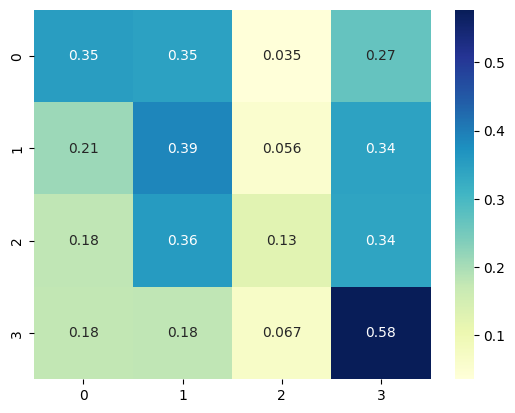

In [39]:
# Assigning the fitted LogisticRegression model with best parameter combination to a new variable log_reg_best_rs_kappa
log_reg_best_rs_kappa = rs_kappa.best_estimator_

# Making predictions on the test set
y_pred_test_rs_kappa = log_reg_best_rs_kappa.predict(X_test)

# Let us print out the performance of our model on the test set.
our_metrics(y_test, y_pred_test_rs_kappa, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3925
_____________________
Weighted Quadratic Kappa: 0.2925


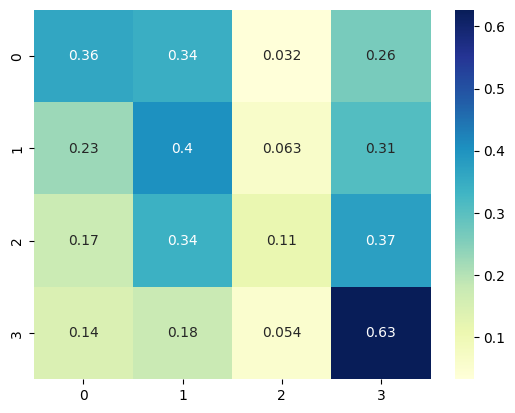

In [40]:
y_pred_train_rs_kappa = log_reg_best_rs_kappa.predict(X_train)
our_metrics(y_train, y_pred_train_rs_kappa, normalize=True)

## Splitting Cats and Dogs

In [59]:
# Logistic Regression
log_reg_cats = LogisticRegression(max_iter=1000)
log_reg_cats.fit(X_train_cats, y_train_cats)

log_reg_dogs = LogisticRegression(max_iter=1000)
log_reg_dogs.fit(X_train_dogs, y_train_dogs)

y_pred_train_cats = log_reg_cats.predict(X_train_cats)
y_pred_test_cats = log_reg_cats.predict(X_test_cats)

y_pred_train_dogs = log_reg_dogs.predict(X_train_dogs)
y_pred_test_dogs = log_reg_dogs.predict(X_test_dogs)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.3874
_____________________
Weighted Quadratic Kappa: 0.2768
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.4068
_____________________
Weighted Quadratic Kappa: 0.3404


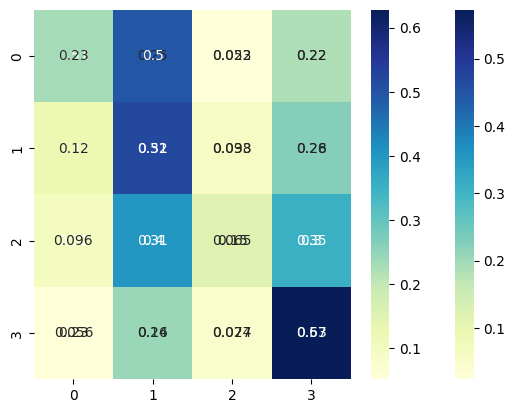

In [60]:
our_metrics(y_train_cats, y_pred_train_cats, normalize=True)
our_metrics(y_train_dogs, y_pred_train_dogs, normalize=True)

Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.269
_____________________
Weighted Quadratic Kappa: 0.0128
Model Metrics and Normalized Confusion Matrix
_____________________
_____________________
Accuracy: 0.2703
_____________________
Weighted Quadratic Kappa: 0.0101


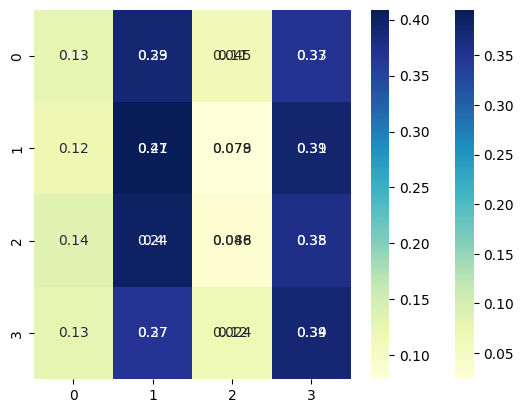

In [61]:
our_metrics(y_test_cats, y_pred_test_cats, normalize=True)
our_metrics(y_test_dogs, y_pred_test_dogs, normalize=True)

### GridSearch

In [43]:
# # Defining parameter grid (as dictionary)
# param_grid = {"loss" : ["hinge", "log_loss", "squared_hinge", "modified_huber"], #this actually defines the model you use
#               "alpha" : [0.0001, 0.001, 0.01, 0.1],
#               "penalty" : ["l2", "l1", None]
#              }

# # Instantiate gridsearch and define the metric to optimize 
# gs = GridSearchCV(SGDClassifier(random_state=RSEED), param_grid, scoring='accuracy',
#                   cv=5, verbose=5, n_jobs=-1)

# # Fit gridsearch object to data.. also lets see how long it takes
# start = timer()
# gs.fit(X_train_preprocessed, y_train)

In [44]:
# # Best score
# print('Best score:', round(gs.best_score_, 3))

# # Best parameters
# print('Best parameters:', gs.best_params_)

In [45]:
# test_proba_49 = class_metrics_var_threshold(eec_best, X_test_tree, y_test_tree, threshold=0.49)
# Changing the threshold slightly does not improve the model:
# * changing the threshold to 0.6 is equivalent to predicting no one commits fraud
# * changing the threshold to 0.49 yields a lot of true positives, hardly any false negatives. However, this comes at the price of a lot of false positive predictions. 
# # get scorers for different thresholds
# test_proba = class_metrics_var_threshold(eec_best, X_test_tree, y_test_tree, threshold=0.5)